# Fruit Classification

https://keras.io/getting-started/faq/#what-does-sample-batch-epoch-mean

## Import Lib

In [20]:
import os, random, math
from pprint import pprint
from datetime import datetime as dt

import numpy as np
import keras as k
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Define constant

In [8]:
#for reproduceability
SEED = 1337
np.random.seed(SEED)

#fruits to model. Same names as the folders under Training
VALID_FRUITS = ["Apricot","Avocado","Banana","Clementine","Granadilla","Kiwi","Limes",
          "Mango","Maracuja","Peach","Pear","Raspberry","Pineapple","Strawberry"]

# image size width x height
IMG_WIDTH=100
IMG_HEIGHT=100
TARGET_SIZE=[IMG_WIDTH, IMG_HEIGHT]

# RGB = 3 channels
CHANNELS=3

# path to image folders
TRAIN_PATH = "Training"
TEST_PATH = "Test"
PREDICTION_PATH = "for-prediction"

#https://keras.io/getting-started/faq/#what-does-sample-batch-epoch-mean
#https://cv-tricks.com/tensorflow-tutorial/training-convolutional-neural-network-for-image-classification/
"""
For computational simplicity, not all training data is fed to the network at once. 
Rather, let’s say we have total 1600 images, we divide them in small batches say of size 16 or 32 called batch-size. 
Hence, it will take 100 or 50 rounds(iterations) for complete data to be used for training. This is called one epoch, 
i.e. in one epoch the networks sees all the training images once. 
"""
BATCH_SIZE=32
EPOCHS=10

# Image processing

In [4]:
#create data generators using default values, except rescale. 
# used to rescale the pixel values from [0, 255] to [0, 1] interval
train_gen = k.preprocessing.image.ImageDataGenerator(
                                         rotation_range=0.1, 
                                         #width_shift_range=0.0, 
                                         width_shift_range=0.1, 
                                         #height_shift_range=0.0, 
                                         height_shift_range=0.1, 
                                         brightness_range=[0.5, 1.5], 
                                         #shear_range=0.0, 
                                         #zoom_range=0.05, 
                                         #channel_shift_range=0.0, 
                                         channel_shift_range=0.05, 
                                         #fill_mode='nearest', 
                                         #cval=0.0, 
                                         #horizontal_flip=False, 
                                         #vertical_flip=False, 
                                         rescale=1./255, 
                                         #preprocessing_function=None, 
                                         #data_format=None, 
                                         #validation_split=0.0, 
                                         #dtype=None
)

test_gen = k.preprocessing.image.ImageDataGenerator(
                                        rotation_range=0.1, 
                                        width_shift_range=0.1, 
                                        height_shift_range=0.1, 
                                        brightness_range=[0.5, 1.5], 
                                        #zoom_range=0.05
                                        channel_shift_range=0.05, 
                                        rescale=1./255
)

In [9]:
#create images iterators
"""
flow_from_directory() automatically infers the labels from the directory structure of the folders containing images. 
Every subfolder inside the training-folder(or validation-folder) will be considered a target class.
"""
train_images_iter = train_gen.flow_from_directory(TRAIN_PATH,                                                            
                                                           target_size = TARGET_SIZE,
                                                           classes = VALID_FRUITS, 
                                                           class_mode = 'categorical',
                                                           #seed = SEED
                                                 )

test_images_iter = test_gen.flow_from_directory(TEST_PATH, 
                                                           target_size = TARGET_SIZE,
                                                           classes = VALID_FRUITS,
                                                           class_mode = 'categorical',
                                                           #seed = SEED
                                               )

Found 6781 images belonging to 14 classes.
Found 2283 images belonging to 14 classes.


In [10]:
def get_subplot_grid(mylist, columns, figwidth, figheight):
    plot_rows = math.ceil(len(mylist) / 2.)
    fig, ax = plt.subplots(plot_rows, 2, sharey=True, sharex=False)
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.subplots_adjust(hspace=0.4)
    axflat = ax.flat
    #remove the unused subplot, if any
    for ax in axflat[ax.size - 1:len(mylist) - 1:-1]:
        ax.set_visible(False)

    return fig, axflat

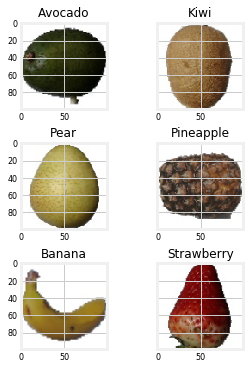

<Figure size 432x288 with 0 Axes>

In [14]:
test_images_classes = ["Avocado","Kiwi","Pear","Pineapple","Banana","Strawberry"]
test_images=[]

plt.rc('font',family = 'sans-serif',  size=8)
fig, axflat = get_subplot_grid(mylist=test_images_classes, columns=2, figwidth=4, figheight=6)

for idx, label in enumerate(test_images_classes):
    image_folder = os.path.join(TRAIN_PATH, label)
    image_file = os.path.join(image_folder, random.choice(os.listdir(image_folder)) )
    loaded_image = k.preprocessing.image.load_img(path=image_file,target_size=(IMG_WIDTH,IMG_HEIGHT,CHANNELS))
    #convert to array and resample dividing by 255
    img_array = k.preprocessing.image.img_to_array(loaded_image) / 255.
    test_images.append({"idx":idx, "image":img_array, "label": label})
    
    axflat[idx].set_title(label, size=12)
    axflat[idx].imshow(img_array)
plt.show()
plt.gcf().clear()

In [15]:
#train_images_iter.class_indices contain the label-index map for each inferred class
#this should match the sort order in VALID_FRUITS
trained_classes_labels = list(train_images_iter.class_indices.keys())
train_images_iter.class_indices

{'Apricot': 0,
 'Avocado': 1,
 'Banana': 2,
 'Clementine': 3,
 'Granadilla': 4,
 'Kiwi': 5,
 'Limes': 6,
 'Mango': 7,
 'Maracuja': 8,
 'Peach': 9,
 'Pear': 10,
 'Raspberry': 11,
 'Pineapple': 12,
 'Strawberry': 13}

In [16]:

#train_images_iter.classes contains a list of classes of each image
unique, counts = np.unique(train_images_iter.classes, return_counts=True)
print ("number of samples per class")
dict(zip(train_images_iter.class_indices, counts))

number of samples per class


{'Apricot': 492,
 'Avocado': 427,
 'Banana': 490,
 'Clementine': 490,
 'Granadilla': 490,
 'Kiwi': 466,
 'Limes': 490,
 'Mango': 490,
 'Maracuja': 490,
 'Peach': 492,
 'Pear': 492,
 'Raspberry': 490,
 'Pineapple': 490,
 'Strawberry': 492}

# Build model

In [22]:
def build_model():
    #build model
   # Initialising the CNN
    classifier = Sequential()

    # Step 1 - Convolution
    classifier.add(Conv2D(32, (5, 5), input_shape = (100, 100, 3), activation = 'relu'))

    # Step 2 - Pooling
    classifier.add(MaxPooling2D(pool_size = (2, 2), strides= 2))


    # Adding a second convolutional layer
    classifier.add(Conv2D(64, (5, 5), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2), strides= 2))

    # Adding a third convolutional layer
    classifier.add(Conv2D(128, (5, 5), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2), strides= 2))

    # Adding a third convolutional layer
    classifier.add(Conv2D(256, (5, 5), activation = 'relu'))
    classifier.add(Dropout(0.25))
    classifier.add(MaxPooling2D(pool_size = (2, 2), strides= 2))

    # Step 3 - Flattening
    classifier.add(Flatten())

    # Step 4 - Full connection
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dropout(0.25))
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dropout(0.25))
    classifier.add(Dense(units = len(trained_classes_labels), activation = 'softmax'))

    return classifier


my_model = build_model()

# Compile

In [23]:
# compile the model
my_model.compile(loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'], 
                    optimizer = k.optimizers.RMSprop(lr = 1e-4, decay = 1e-6)
                    #optimizer = k.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
                    #optimizer = k.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
                    #optimizer = k.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
                )

# Train/fit

In [24]:

# train the model
start = dt.now()
history = my_model.fit_generator(
  # training data
  train_images_iter,

  # epochs
  steps_per_epoch = train_images_iter.n // BATCH_SIZE, #floor per batch size
  epochs = EPOCHS, 

  # validation data
  validation_data = test_images_iter,
  validation_steps = test_images_iter.n // BATCH_SIZE,

  # print progress
  verbose = 1,
  callbacks = [
    #early stopping in case the loss stops decreasing
    k.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    # only save the model if the monitored quantity (val_loss or val_acc) has improved
    k.callbacks.ModelCheckpoint("fruits_checkpoints.h5", monitor='val_loss', save_best_only = True),
    # only needed for visualising with TensorBoard
    #k.callbacks.TensorBoard(log_dir = "logs/{:%d_%b_%Y_%H:%M:%S}".format(dt.now()) )
  ]
)


Epoch 1/10
211/211 [==============================] - 115s 544ms/step - loss: 1.5318 - accuracy: 0.4876 - val_loss: 0.8404 - val_accuracy: 0.7491
Epoch 2/10
211/211 [==============================] - 116s 551ms/step - loss: 0.6212 - accuracy: 0.7859 - val_loss: 0.3060 - val_accuracy: 0.9045
Epoch 3/10
211/211 [==============================] - 114s 540ms/step - loss: 0.3390 - accuracy: 0.8912 - val_loss: 0.1749 - val_accuracy: 0.9374
Epoch 4/10
211/211 [==============================] - 120s 567ms/step - loss: 0.2203 - accuracy: 0.9327 - val_loss: 0.2353 - val_accuracy: 0.9387
Epoch 5/10
211/211 [==============================] - 125s 591ms/step - loss: 0.1508 - accuracy: 0.9544 - val_loss: 0.0141 - val_accuracy: 0.9876
Epoch 6/10
211/211 [==============================] - 121s 572ms/step - loss: 0.1227 - accuracy: 0.9628 - val_loss: 0.0216 - val_accuracy: 0.9813
Epoch 7/10
211/211 [==============================] - 119s 566ms/step - loss: 0.0956 - accuracy: 0.9745 - val_loss: 0.1552 

In [25]:
my_model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

# Plot

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


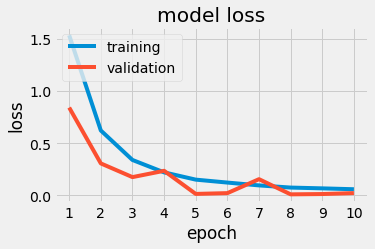

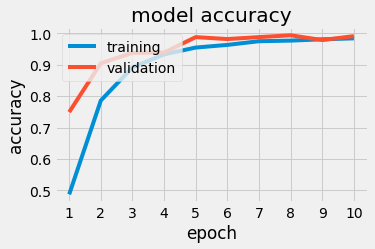

In [30]:
print(history.history.keys())

plt.style.use('fivethirtyeight')

xepochs = [i+1 for i in range(0, len(history.history['loss']))]
plt.figure(figsize=(5,3))
# Loss
#plt.ylim([-0.1,0.5])
plt.plot(xepochs, history.history['loss'])
plt.plot(xepochs, history.history['val_loss'])
plt.xticks(xepochs)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# Accuracy
#plt.ylim([0.7,1.05])
plt.figure(figsize=(5,3))
plt.plot(xepochs, history.history['accuracy'])
plt.plot(xepochs, history.history['val_accuracy'])
plt.xticks(xepochs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# Load trained model

In [33]:
#load model checkpoint
#assumes my_model variable is created and structure is set
my_trained_model=build_model()
# load weights
my_trained_model.load_weights("my_model.h5")
# Compile model (required to make predictions)
my_trained_model.compile(loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'], 
                    optimizer = k.optimizers.RMSprop(lr = 1e-4, decay = 1e-6)
                )
print("Created model and loaded weights from file")

Created model and loaded weights from file


In [32]:
my_trained_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 96, 96, 32)        2432      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 44, 44, 64)        51264     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 18, 128)       204928    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 5, 256)        

# Predict image

In [ ]:

# name_of_classes = [ "Apple Braeburn", "Apple Golden 1", "Apple Golden 2", "Apple Golden 3" , "Apple Granny Smith" ,"Apple Red 1" ,"Apple Red 2" ,"Apple Red 3" ,"Apple Red Delicious" ,"Apple Red Yellow" ,"Apricot" ,"Avocado","Avocado ripe" ,"Banana" ,"Banana Red" ,"Cactus fruit" ,"Carambula" ,"Cherry" ,"Clementine" ,"Cocos" ,"Dates" ,"Granadilla" ,"Grape Pink" ,"Grape White" ,"Grape White 2" ,"Grapefruit Pink" ,"Grapefruit White" ,"Guava" ,"Huckleberry" ,"Kaki" ,"Kiwi" ,"Kumquats" ,"Lemon" ,"Lemon Meyer" ,"Limes" ,"Litchi" ,"Mandarine" ,"Mango" ,"Maracuja" ,"Nectarine" ,"Orange" ,"Papaya" ,"Passion Fruit" ,"Peach" ,"Peach Flat" ,"Pear" ,"Pear Abate" ,"Pear Monster" ,"Pear Williams" ,"Pepino" ,"Pineapple" ,"Pitahaya Red" ,"Plum" ,"Pomegranate" ,"Quince" ,"Raspberry" ,"Salak" ,"Strawberry" ,"Tamarillo" , "Tangelo"]


# test_image = image.load_img('banana.jpg', target_size = (100, 100))
# test_image = image.img_to_array(test_image)
# test_image = np.expand_dims(test_image, axis = 0)
# result = classifier.predict(test_image)
# Training.class_indices
# img = 'banana.jpg'
# Image.open(img)

In [42]:
# my_trained_model.class_indices

{'Apricot': '0.31%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '99.69%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%'}
 Bananas(lady_finger)2.jpg  Prediction: Maracuja (class 8) 99.69%


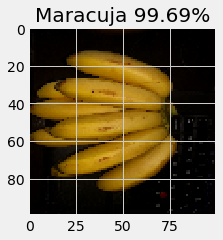

{'Apricot': '0.00%',
 'Avocado': '90.66%',
 'Banana': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '9.34%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%'}
 apple.jpg  Prediction: Avocado (class 1) 90.66%


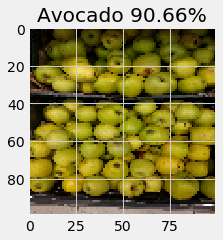

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '100.00%'}
 apple_apricot_peach_peach(flat)_pomegranate_pear_plum_2.jpg  Prediction: Strawberry (class 13) 100.00%


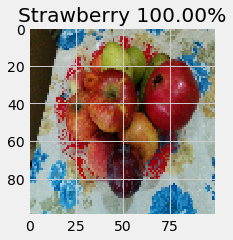

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.14%',
 'Clementine': '0.07%',
 'Granadilla': '2.09%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.10%',
 'Maracuja': '0.00%',
 'Peach': '3.77%',
 'Pear': '0.00%',
 'Pineapple': '1.95%',
 'Raspberry': '0.47%',
 'Strawberry': '91.41%'}
 cherries_wax1.jpg  Prediction: Strawberry (class 13) 91.41%


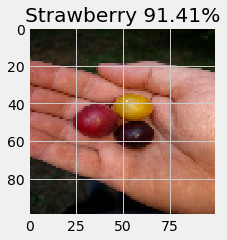

{'Apricot': '0.00%',
 'Avocado': '0.18%',
 'Banana': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '99.82%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%'}
 mango.jpg  Prediction: Maracuja (class 8) 99.82%


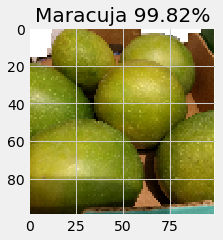

{'Apricot': '0.01%',
 'Avocado': '0.54%',
 'Banana': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '99.44%',
 'Peach': '0.00%',
 'Pear': '0.01%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%'}
 mangos_bananas(lady_finger).jpg  Prediction: Maracuja (class 8) 99.44%


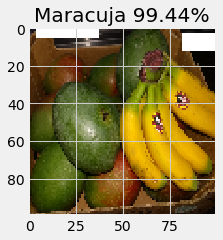

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.09%',
 'Strawberry': '99.90%'}
 raspberries8.jpg  Prediction: Strawberry (class 13) 99.90%


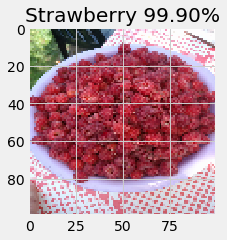

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '100.00%'}
 strawberries5.jpg  Prediction: Strawberry (class 13) 100.00%


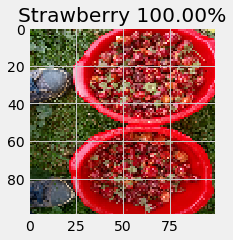

<Figure size 432x288 with 0 Axes>

In [40]:
#predict image

images_for_prediction = [filename for filename in sorted(os.listdir(PREDICTION_PATH)) if filename.endswith(".jpg")]


for filename in images_for_prediction:
    loaded_image = k.preprocessing.image.load_img(path=PREDICTION_PATH+'/'+filename, target_size=(IMG_WIDTH,IMG_HEIGHT,CHANNELS))
    #convert to array and resample dividing by 255
    img_array = k.preprocessing.image.img_to_array(loaded_image) / 255.

    #add sample dimension. the predictor is expecting (1, CHANNELS, IMG_WIDTH, IMG_HEIGHT)
    img_np_array = np.expand_dims(img_array, axis = 0)

    predictions = my_trained_model.predict(img_np_array)
    classidx = np.argmax(predictions[0])
    label = trained_classes_labels[classidx]

    predictions_pct = ["{:.2f}%".format(prob * 100) for prob in predictions[0] ]
    pprint(dict(zip(trained_classes_labels, predictions_pct)) )
    print(" %s  Prediction: %s (class %s) %s" % (filename,label, classidx, predictions_pct[classidx])) 
  
    plt.figure(figsize=(3,4))
    plt.imshow(img_array)
    plt.title("%s %s" % (label, predictions_pct[classidx]))
    plt.show()

plt.gcf().clear()